In [10]:
# Import libraries
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate, stats

sns.set_theme(style="whitegrid")

# Analysis of the Stack Overflow Annual Survey of 2025

Every year, Stack Overflow surveys thousands of users around the world to understand their experiences, preferences, and challenges. In this project I analyze the results of the survey and compile the results in a blog post.

## Step 1: Data Gathering

The datasets were downloaded from https://survey.stackoverflow.co/ and copied in the /data folder.
* survey_results_plublic.zip
* survey_results_schema.csv

## Step 2: Data Assessment

The data is explored in the notebook 01_data_understanding.ipynb. The aim is to find a good story to tell in the blog. 

The following aspects are explored:
- Personal data
    - Age
    - Education level
    - Employment &#x2705;
    - Additional employment
    - Years of work experience &#x2705;
    - Years of coding employment
    - Developer type
    - Main work branch &#x2705;
    - Industry
- Learning
    - Learning to code and approach
    - Learning AI and approach
- Technology
    - Endorsing factors
    - Opposing factors
- Job satisfaction
    - Level &#x2705;
    - Attributes &#x2705;
    - Role changing
- Coding
    - Coding language used, want to use and admired
    - Databases used, want to use and admired
    - Development platforms used, want to use and admired
    - Webframe used, want to use and admired
    - Development environmen used, want to use and admired
    - Help platforms used, want to use and admired
- AI
    - Usage frequency &#x2705;
    - Sentiment towards AI
    - Threat perception &#x2705;
    - Trust perception
    - Frustration
    - AI models used, want to use and admired
    - AI tools planned to use and not use

A checkbox &#x2705; indicates which results were included in the blog post story.


## Step 3: Data Cleaning

For this analysis, I will focus on professional developers with at least three years of experience, who were employed or self-employed at the time of the survey. I will also exclude responses from participants who did not answer the Job Satisfaction question to ensure the integrity of our results.

In [11]:
# Load the data
df = pd.read_csv(Path("../data/survey_results_public.zip"))

# Filter table
df2 = (
    df[
        (df["MainBranch"]=="I am a developer by profession") & 
        (df["Employment"].isin(["Employed", "Independent contractor, freelancer, or self-employed"])) & 
        (df["WorkExp"] >= 3.0) & 
        (df["YearsCode"] >= 3.0) & 
        (~df["JobSat"].isna())
    ])

## Step 4: Data Analysis

The main question I want to answer is **what drives job satisfaction among developers?**

### Business Question 1: How satisfied are developers with their job?

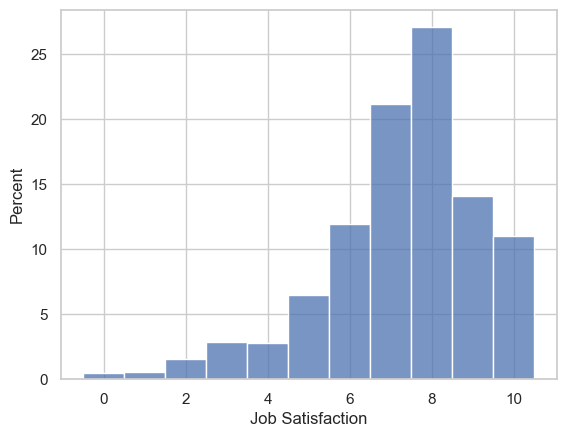

In [12]:
sns.histplot(df2, x="JobSat", bins=np.linspace(-0.5, 10.5, 12), stat="percent")
plt.xlabel("Job Satisfaction")
plt.show()

**Answer**:

A histogram of job satisfaction scores (ranging from 0 to 10) reveals that developers tend to report high levels of satisfaction. The most frequently selected score is 8, indicating that many developers are generally content with their work.

### Business Question 2: What factors play a major role in job satisfaction?

One survey question offers valuable insight by asking participants to rank a list of job attributes based on how much they contribute to overall satisfaction, from most to least important. The figure below illustrates the percentage of times each attribute was assigned to each rank, with attributes sorted so that those most frequently ranked highly appear at the top. This gives us a clearer picture of what developers value most in their work.

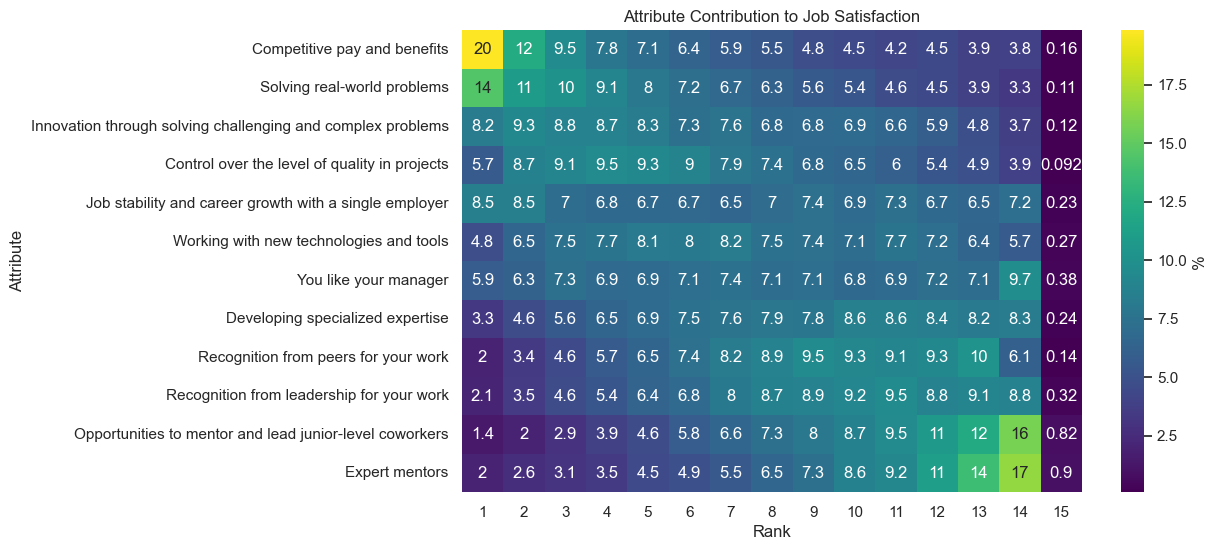

In [13]:
# Convert column ID to attribute text
df_schema = pd.read_csv(Path("../data/survey_results_schema.csv"))
dict_schema = pd.Series(df_schema["sub"].values,index=df_schema["qname"]).dropna().to_dict()

# Melt attribute columns into a two rows
melted_df = (df2
             .filter(regex=r"^JobSatPoints_(?!.*_TEXT$)", axis=1)
             .rename(columns=dict_schema)
             .dropna(how='all')
             .melt(var_name='Attribute', value_name='Rank')
                )
melted_df["Rank"] = melted_df["Rank"].astype(int)

# Count occurrences of each rank per option
rank_counts = melted_df.groupby(['Attribute', 'Rank']).size().reset_index(name='Count')

# Pivot the table to create a matrix format
matrix_df = rank_counts.pivot(index='Attribute', columns='Rank', values='Count').fillna(0)

# Remove "Other" option
matrix_df = matrix_df.loc[~matrix_df.index.str.startswith("Other")] 

# Normalize to 100%
matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0) * 100

# Sort to have the highest ranked attribute on top
total_points = np.sum(matrix_df.to_numpy() * np.arange(matrix_df.shape[1], 0, -1)[None, :], axis=1)
matrix_df = matrix_df.iloc[np.argsort(total_points)[::-1]]

# Create plot
plt.figure(figsize=(10, 6))    
sns.heatmap(matrix_df, annot=True, cmap='viridis', cbar_kws={'label': '%'})
plt.title("Attribute Contribution to Job Satisfaction")
plt.show()

**Answer**: 
- The clear winner is compensation, which stands out as the most important factor by a wide margin.
- Next comes a cluster of attributes related to what is being developed — including interest in the problem being solved, the level of innovation, and the tools used.
- Job stability rounds out the top tier, highlighting the importance of security in a developer’s professional life.
- Liking one’s manager ranks relatively low. 
- Recognition and leadership consistently appear at the bottom of the rankings, making them the least influential factors in developer job satisfaction. 

### Business Question 3: Does earning more directly translates to greater job satisfaction?

To explore this, let's examine the survey data whether compensation correlates with how satisfied developers feel in their roles.

The plot on the left displays the cumulative distribution of developer salaries, with curves color-coded by job satisfaction levels. A curve that shifts further to the right indicates higher salaries among that group. For instance, 46% of developers who report a job satisfaction score of 10 earn a six-digit salary or more, compared to just 30% of those with a satisfaction score of 4.

The plot on the right shows the area under the salary distribution curve as a function of satisfaction.

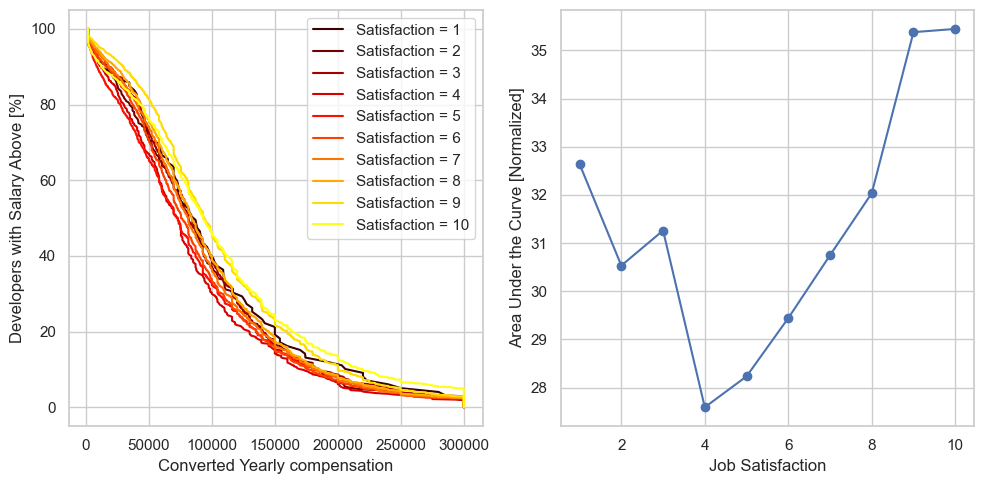

In [14]:
# Cumulative plots and AUC
gic, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

min = df2["ConvertedCompYearly"].quantile(0.025)
max = df2["ConvertedCompYearly"].quantile(0.975)

# for the area under the curve
x_common = np.linspace(min, max, 500)
auc = [0] * 10

# Make cumulative plot, zoom and AUC
colors = plt.cm.hot(np.linspace(0,1,14))
for sat in range(1, 11):
    values = (df2[df2["JobSat"] == sat]["ConvertedCompYearly"]
              .dropna()
              .clip(lower=min, upper=max)
              .sort_values()
              .to_numpy())
    percentiles = 100 - np.linspace(0, 100, len(values))
    ax1.plot(values, percentiles, label=f"Satisfaction = {sat}", color=colors[sat])

    interp_func = interpolate.interp1d(values, percentiles, bounds_error=False, fill_value=(100, 0))
    y_interp = interp_func(x_common)
    auc[sat-1] = np.trapezoid(interp_func(x_common), x_common) / ((max - min))
    
ax1.legend()
ax1.set_xlabel("Converted Yearly compensation")
ax1.set_ylabel("Developers with Salary Above [%]")

ax2.plot(range(1, 11), auc, '-o')
ax2.set_xlabel("Job Satisfaction")
ax2.set_ylabel("Area Under the Curve [Normalized]")

plt.tight_layout()
plt.show()

**Answer**:

A higher compensation tends to correlate with higher job satisfaction.

However, this doesn’t tell the whole story. On one hand, there are plenty of developers earning high salaries who report low satisfaction, and vice versa. While the area under the cumulative salary curve generally increases with satisfaction, an interesting reversal occurs below a satisfaction level of 4: developers in this group tend to have higher compensation than those just above them in satisfaction.

### Business Question 4: What is the impact of AI on job satisfaction?

One possible explanation for this disconnect is uncertainty about how AI might reshape the developer role. The survey reveals widespread adoption of AI tools, even though trust in their outputs varies significantly. While innovation and learning new technologies rank high among the factors contributing to job satisfaction, job stability ranks even higher. This tension could explain why some developers report lower satisfaction despite earning high salaries, since they may feel that rapid technological change threatens long-term security.

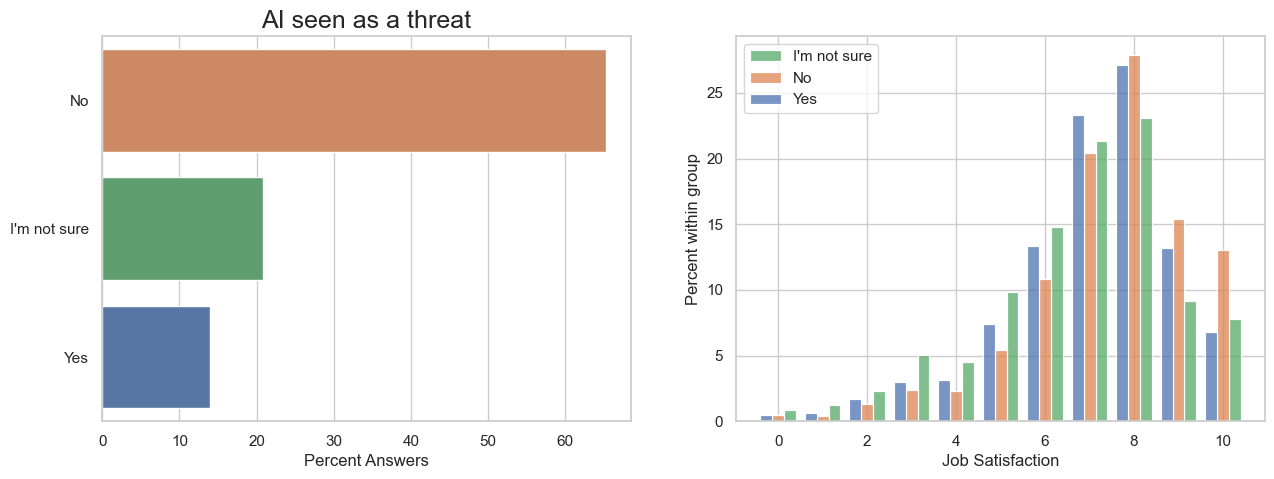

In [15]:
# histogram of AI seen as threat vs job satisfaction
gic, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

palette = sns.color_palette()[:3]
f = df2[df2["AIThreat"].isin(['No', 'Yes', "I'm not sure"])]

sns.countplot(f, y="AIThreat" , order = f["AIThreat"].value_counts().index, stat="percent", ax=ax1, hue="AIThreat", palette=[palette[2], palette[1], palette[0]])
ax1.set_xlabel("Percent Answers")
ax1.set_ylabel("")
ax1.set_title("AI seen as a threat", fontsize=18)

sns.histplot(f, x="JobSat", hue="AIThreat", bins=np.arange(-0.5, 11.5), stat="percent", multiple="dodge", shrink=0.8, common_norm=False, ax=ax2)
ax2.set_xlabel("Job Satisfaction")
ax2.set_ylabel("Percent within group")
ax2.legend(title='', loc='upper left', labels=["I'm not sure", "No", "Yes"]);

In [16]:
# statistical test
negative = df2[df2["AIThreat"].isin(['No'])]["JobSat"].to_numpy()
positive = df2[df2["AIThreat"].isin(['Yes', "I'm not sure"])]["JobSat"].to_numpy()

u_stat, p_value = stats.mannwhitneyu(negative, positive, alternative='greater')

print("Mann–Whitney U test")
print(f"  U statistic: {u_stat:.3f}")
print(f"  p-value (two-sided): {p_value:.4f}")

Mann–Whitney U test
  U statistic: 67114232.000
  p-value (two-sided): 0.0000


**Answer**:

The histogram on the left shows that 35% of developers view AI as a threat or remain uncertain about its impact, a notably high figure. The histogram on the right breaks down job satisfaction within each response group. Developers with satisfaction scores of 8 or higher tend to be less concerned about AI replacing their jobs, while the opposite trend appears among those with lower satisfaction. 

This relationship is statistically supported by a Mann-Whitney U test, which confirms that developers who do not perceive AI as a threat report significantly higher job satisfaction.